In [34]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from torch import Tensor
import torch.nn.functional as F
from torch.optim import AdamW, Optimizer
from torch.utils.data import DataLoader, Dataset
from typing import Callable, Optional, Tuple

from torchvision import transforms
from tqdm import tqdm

from sklearn import cluster, datasets
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


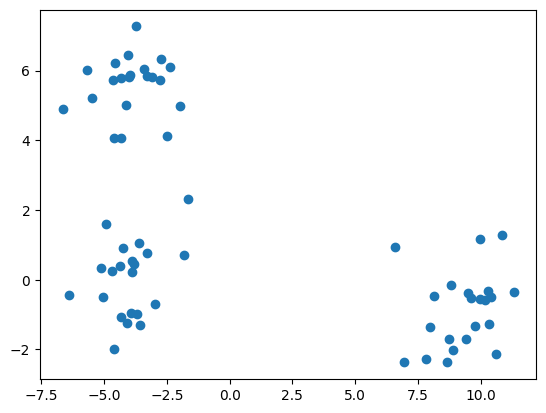

In [25]:
n_dp = 3000
n_samples = 64
varied = np.array([datasets.make_blobs(
    n_samples=n_samples,
    centers=3, n_features=2
)[0] for _ in range(n_dp)])

plt.scatter(varied[0][:,0], varied[0][:, 1])
plt.show()

In [40]:
class SlotAttentionFixedEM(nn.Module):
    def __init__(
        self,
        input_dim: int = 2,
        num_slots: int = 7,
        slot_dim: int = 2,
        routing_iters: int = 3,
        hidden_dim: int = 2,
    ):
        super().__init__()
        self.num_slots = num_slots
        self.slot_dim = slot_dim
        self.routing_iters = routing_iters

        self.loc = nn.Parameter(torch.zeros(1, self.slot_dim))
        self.logscale = nn.Parameter(torch.zeros(1, self.slot_dim))
        self.eps = 1e-6

    def forward(self, x: Tensor, num_slots: Optional[int] = None):
        # b: batch_size, n: num_inputs, c: input_dim, K: num_slots, d: slot_dim
        b, N, d = x.shape
        # (b, n, c)
        # x = self.ln_inputs(x)

        # (b, k, d)
        K = num_slots if num_slots is not None else self.num_slots
        slots = self.loc + self.logscale.exp() * torch.randn(
            b, K, self.slot_dim, device=x.device
        )

        pi = torch.ones(b, K, 1, device = x.device, dtype = x.dtype)/K
        sigma = self.logscale.exp().unsqueeze(1).repeat(1, K, 1)
        

        for _ in range(self.routing_iters):
            slots_prev = slots

            # E-step
            log_pi    = - 0.5 * torch.tensor(2 * torch.pi, device=x.device).log()
            log_scale = - torch.log(torch.clamp(sigma.unsqueeze(2), min = self.eps)) # (B, K, N, d)
            exponent  = - 0.5 * (x.unsqueeze(1) - slots_prev.unsqueeze(2)) ** 2 / (sigma.unsqueeze(2)) ** 2 # (B, K, N, d)
            log_probs = torch.log(torch.clamp(pi, min = self.eps)) + (exponent + log_pi + log_scale).sum(dim=-1) # (B, K, N)
                            
            attn = log_probs.softmax(dim=1) + self.eps # (B, K, N)


            # M-step
            Nk = torch.sum(attn, dim=2, keepdim=True) # (B, K, 1)
            pi = Nk / N
            
            slots = (1 / Nk) * torch.sum(attn.unsqueeze(-1) * x.unsqueeze(1), dim=2) # (B, K, D)

            sigma = (1 / Nk) * torch.sum(attn.unsqueeze(-1) * (x.unsqueeze(1) - slots.unsqueeze(2))**2, dim=2) # (B, K, D)
            sigma = torch.sqrt(sigma) + self.eps
            
        return slots, sigma, attn, pi


class PositionEmbed(nn.Module):
    def __init__(self, out_channels: int = 2, resolution: int = 1500):
        super().__init__()
        # (1, N, 2)
        lp = torch.linspace(0.0, 1.0, steps=resolution).unsqueeze(-1)
        self.grid = torch.cat([lp, 1.0 - lp], dim=-1).unsqueeze(0)
        self.mlp = nn.Linear(2, out_channels)  # 4 for (x, y, 1-x, 1-y)

    def forward(self, x: Tensor):
        # (1, N, out_channels)
        grid = self.mlp(self.grid)
        # (batch_size, out_channels, height, width)
        return x + grid

    def build_grid(self, resolution: Tuple[int, int]) -> Tensor:
        xy = [torch.linspace(0.0, 1.0, steps=r) for r in resolution]
        xx, yy = torch.meshgrid(xy, indexing="ij")
        grid = torch.stack([xx, yy], dim=-1)
        grid = grid.unsqueeze(0)
        return torch.cat([grid, 1.0 - grid], dim=-1)

class SlotAutoencoder(nn.Module):
    def __init__(
        self,
        num_inputs: int = 1500,
        emb_dim: int = 2,
        num_slots: int = 10,
        slot_dim: int = 2,
        routing_iters: int = 1,
        slot_type: Optional[str] = "fixedEM",
    ):
        super().__init__()
        enc_act = nn.ReLU()
        self.encoder = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            enc_act,
            PositionEmbed(emb_dim, num_inputs),
            nn.Linear(emb_dim, emb_dim)
        )

        
        self.slot_attention = SlotAttentionFixedEM(
            input_dim=emb_dim,
            num_slots=num_slots,
            slot_dim=slot_dim,
            routing_iters=routing_iters,
            hidden_dim=emb_dim,
        )


        dec_act = nn.LeakyReLU()
        self.decoder = nn.Sequential(
            PositionEmbed(slot_dim, num_inputs),
            nn.Linear(slot_dim, emb_dim),
            dec_act,
            nn.Linear(emb_dim, emb_dim + 1),
            # dec_act,
            # nn.Linear(emb_dim + 1, emb_dim + 1)
        )

    def forward(self, x: Tensor):
        # b: batch_size, c: channels, h: height, w: width, d: out_channels
        b, n, d = x.shape
        # (b, d, h, w)
        x = self.encoder(x)

        # (b, num_slots, slot_dim)
        slots, sigma, attn, pi = self.slot_attention(x)

        # (b*num_slots, slot_dim, init_h, init_w)
        x = slots.view(-1, slots.shape[-1])[:, None, :]
        x = x.repeat(1, n, 1)
        # (b*num_slots, c + 1, h, w)
        x = self.decoder(x)

        # (b, num_slots, c + 1, h, w)
        x = x.view(b, -1, n, d + 1)
        # (b, num_slots, n, d), (b, num_slots, n, 1)
        recons, masks = torch.split(x, [d, 1], dim=3)
        masks = masks.softmax(dim=1)
        # (b, c, h, w)
        recon_combined = torch.sum(recons * masks, dim=1)
        return recon_combined, recons, masks, slots, sigma, attn, pi

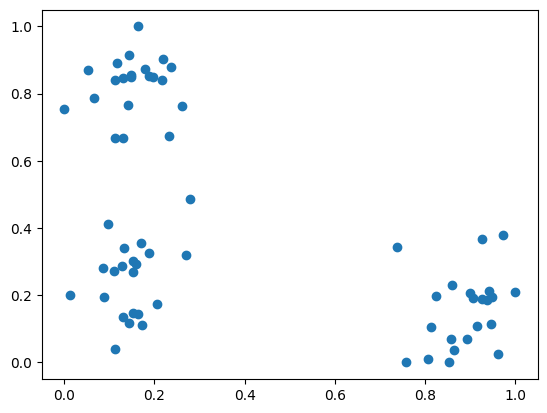

In [60]:
data = torch.from_numpy(varied).type(torch.float32)
data = (data - data.mean(1, keepdim=True))/data.std(1, keepdim=True)
data = (data - data.min(1, keepdim=True)[0])/(data.max(1, keepdim=True)[0] - data.min(1, keepdim=True)[0] + 1e-5)

v_numpy = data[0].detach().cpu().numpy()
plt.clf()
plt.scatter(v_numpy[:,0], v_numpy[:, 1])
plt.show()
        
nepochs = 50
lr = 0.1
wd = 1e-6
num_slots = 3
num_inputs = v_numpy.shape[0] 
routing_iters = 5

In [ ]:
model = SlotAutoencoder(num_slots = num_slots, 
                        num_inputs = num_inputs, 
                        routing_iters = num_inputs)
optimizer = AdamW(
        model.parameters(), 
        lr=lr, 
        weight_decay=wd
    )

loss_np = 0
pbar = tqdm(range(nepochs))

for _  in pbar:
    optimizer.zero_grad()
    x, _, _, slots, sigma, attn, pi = model(data)
    loss = F.mse_loss(x, data)
    # x = F.sigmoid(x)
    # loss = F.binary_cross_entropy(x, data) 
    loss.backward()
    optimizer.step()

    loss_np = loss.item()
    pbar.set_description("Training Loss:{:.2f}".format(loss_np))
    

slots = slots[0].detach().cpu(); sigma = sigma[0].detach().cpu(); pi = pi[0].detach().cpu()
dist = torch.distributions.Normal(slots, sigma)
samples = dist.sample([500])

plt.clf()
plt.scatter(samples[:, 0, 0], samples[:, 0, 1], c='sandybrown')
plt.scatter(samples[:, 1, 0], samples[:, 1, 1], c='forestgreen')
plt.scatter(samples[:, 2, 0], samples[:, 2, 1], c='skyblue')


def gaussian_log_prob(x, loc, scale):
    return (
        -0.5 * torch.tensor(2 * torch.pi, device=x.device).log()
        - torch.log(scale)
        - 0.5 * (x - loc) ** 2 / scale ** 2
    )

datanp = samples.view(-1, 2)
x, y = np.meshgrid(np.linspace(datanp[:, 0].min(), datanp[:, 0].max(), 100),
                   np.linspace(datanp[:, 1].min(), datanp[:, 1].max(), 100))

coord = np.array([x.ravel(), y.ravel()]).T
coord = torch.from_numpy(coord).unsqueeze(1)
log_probs = torch.log(pi) + gaussian_log_prob(coord, slots, sigma).sum(dim=-1, keepdim=True)
likelihood = log_probs.exp().sum(dim=1).reshape(x.shape)
plt.contour(x, y, likelihood, levels=10)
plt.tight_layout()

plt.grid()
plt.xlabel('Feature-1')
plt.ylabel('Feature-2')
plt.show()


Training Loss:0.31:   6%|██████████▌                                                                                                                                                                    | 3/50 [00:28<07:30,  9.59s/it]

Training Loss:0.37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]


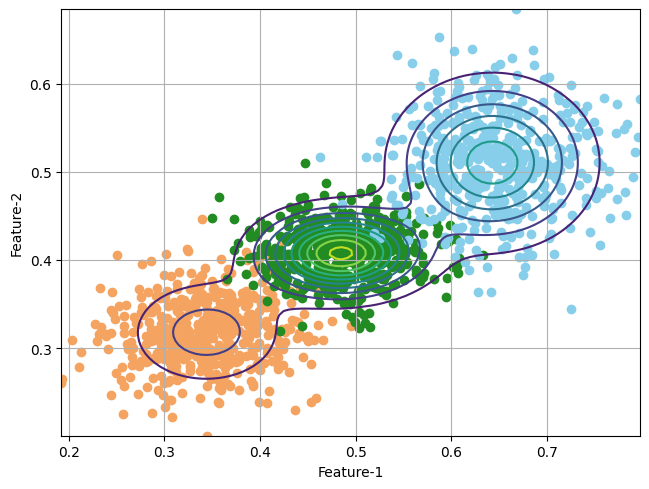

In [58]:
model = SlotAutoencoder(num_slots = num_slots, 
                        num_inputs = num_inputs, 
                        routing_iters = num_inputs)
optimizer = AdamW(
        model.parameters(), 
        lr=lr, 
        weight_decay=wd
    )

loss_np = 0
pbar = tqdm(range(nepochs))

for _  in pbar:
    optimizer.zero_grad()
    x, _, _, slots, sigma, attn, pi = model(data)
    loss = F.mse_loss(x, data)
    # x = F.sigmoid(x)
    # loss = F.binary_cross_entropy(x, data) 
    loss.backward()
    optimizer.step()

    loss_np = loss.item()
    pbar.set_description("Training Loss:{:.2f}".format(loss_np))
    

slots = slots[0].detach().cpu(); sigma = sigma[0].detach().cpu(); pi = pi[0].detach().cpu()
dist = torch.distributions.Normal(slots, sigma)
samples = dist.sample([500])

plt.clf()
plt.scatter(samples[:, 0, 0], samples[:, 0, 1], c='sandybrown')
plt.scatter(samples[:, 1, 0], samples[:, 1, 1], c='forestgreen')
plt.scatter(samples[:, 2, 0], samples[:, 2, 1], c='skyblue')


def gaussian_log_prob(x, loc, scale):
    return (
        -0.5 * torch.tensor(2 * torch.pi, device=x.device).log()
        - torch.log(scale)
        - 0.5 * (x - loc) ** 2 / scale ** 2
    )

datanp = samples.view(-1, 2)
x, y = np.meshgrid(np.linspace(datanp[:, 0].min(), datanp[:, 0].max(), 100),
                   np.linspace(datanp[:, 1].min(), datanp[:, 1].max(), 100))

coord = np.array([x.ravel(), y.ravel()]).T
coord = torch.from_numpy(coord).unsqueeze(1)
log_probs = torch.log(pi) + gaussian_log_prob(coord, slots, sigma).sum(dim=-1, keepdim=True)
likelihood = log_probs.exp().sum(dim=1).reshape(x.shape)
plt.contour(x, y, likelihood, levels=10)
plt.tight_layout()

plt.grid()
plt.xlabel('Feature-1')
plt.ylabel('Feature-2')
plt.show()


Training Loss:0.10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]


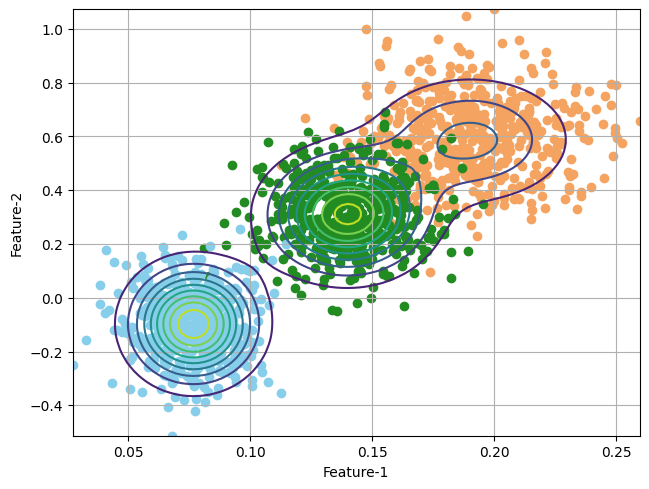

In [55]:
model = SlotAutoencoder(num_slots = num_slots, 
                        num_inputs = num_inputs, 
                        routing_iters = num_inputs)
optimizer = AdamW(
        model.parameters(), 
        lr=lr, 
        weight_decay=wd
    )

loss_np = 0
pbar = tqdm(range(nepochs))

for _  in pbar:
    optimizer.zero_grad()
    x, _, _, slots, sigma, attn, pi = model(data)
    loss = F.mse_loss(x, data)
    # x = F.sigmoid(x)
    # loss = F.binary_cross_entropy(x, data) 
    loss.backward()
    optimizer.step()

    loss_np = loss.item()
    pbar.set_description("Training Loss:{:.2f}".format(loss_np))
    

slots = slots[0].detach().cpu(); sigma = sigma[0].detach().cpu(); pi = pi[0].detach().cpu()
dist = torch.distributions.Normal(slots, sigma)
samples = dist.sample([500])

plt.clf()
plt.scatter(samples[:, 0, 0], samples[:, 0, 1], c='sandybrown')
plt.scatter(samples[:, 1, 0], samples[:, 1, 1], c='forestgreen')
plt.scatter(samples[:, 2, 0], samples[:, 2, 1], c='skyblue')


def gaussian_log_prob(x, loc, scale):
    return (
        -0.5 * torch.tensor(2 * torch.pi, device=x.device).log()
        - torch.log(scale)
        - 0.5 * (x - loc) ** 2 / scale ** 2
    )

datanp = samples.view(-1, 2)
x, y = np.meshgrid(np.linspace(datanp[:, 0].min(), datanp[:, 0].max(), 100),
                   np.linspace(datanp[:, 1].min(), datanp[:, 1].max(), 100))

coord = np.array([x.ravel(), y.ravel()]).T
coord = torch.from_numpy(coord).unsqueeze(1)
log_probs = torch.log(pi) + gaussian_log_prob(coord, slots, sigma).sum(dim=-1, keepdim=True)
likelihood = log_probs.exp().sum(dim=1).reshape(x.shape)
plt.contour(x, y, likelihood, levels=10)
plt.tight_layout()

plt.grid()
plt.xlabel('Feature-1')
plt.ylabel('Feature-2')
plt.show()


Training Loss:0.38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]


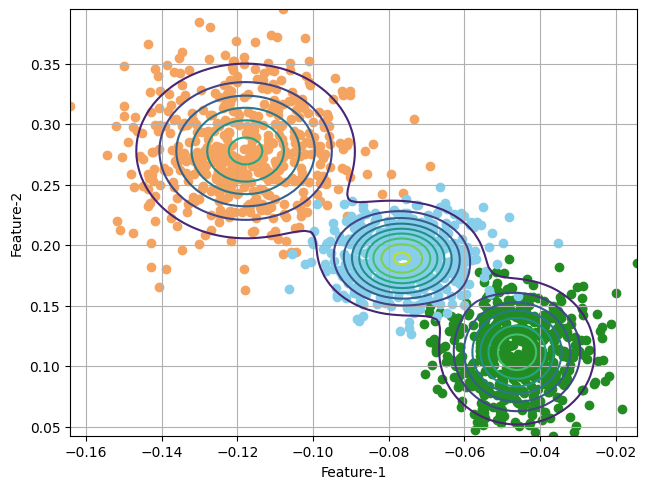

In [56]:
model = SlotAutoencoder(num_slots = num_slots, 
                        num_inputs = num_inputs, 
                        routing_iters = num_inputs)
optimizer = AdamW(
        model.parameters(), 
        lr=lr, 
        weight_decay=wd
    )

loss_np = 0
pbar = tqdm(range(nepochs))

for _  in pbar:
    optimizer.zero_grad()
    x, _, _, slots, sigma, attn, pi = model(data)
    loss = F.mse_loss(x, data)
    # x = F.sigmoid(x)
    # loss = F.binary_cross_entropy(x, data) 
    loss.backward()
    optimizer.step()

    loss_np = loss.item()
    pbar.set_description("Training Loss:{:.2f}".format(loss_np))
    

slots = slots[0].detach().cpu(); sigma = sigma[0].detach().cpu(); pi = pi[0].detach().cpu()
dist = torch.distributions.Normal(slots, sigma)
samples = dist.sample([500])

plt.clf()
plt.scatter(samples[:, 0, 0], samples[:, 0, 1], c='sandybrown')
plt.scatter(samples[:, 1, 0], samples[:, 1, 1], c='forestgreen')
plt.scatter(samples[:, 2, 0], samples[:, 2, 1], c='skyblue')


def gaussian_log_prob(x, loc, scale):
    return (
        -0.5 * torch.tensor(2 * torch.pi, device=x.device).log()
        - torch.log(scale)
        - 0.5 * (x - loc) ** 2 / scale ** 2
    )

datanp = samples.view(-1, 2)
x, y = np.meshgrid(np.linspace(datanp[:, 0].min(), datanp[:, 0].max(), 100),
                   np.linspace(datanp[:, 1].min(), datanp[:, 1].max(), 100))

coord = np.array([x.ravel(), y.ravel()]).T
coord = torch.from_numpy(coord).unsqueeze(1)
log_probs = torch.log(pi) + gaussian_log_prob(coord, slots, sigma).sum(dim=-1, keepdim=True)
likelihood = log_probs.exp().sum(dim=1).reshape(x.shape)
plt.contour(x, y, likelihood, levels=10)
plt.tight_layout()

plt.grid()
plt.xlabel('Feature-1')
plt.ylabel('Feature-2')
plt.show()


Training Loss:0.67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:11<00:00,  1.43s/it]


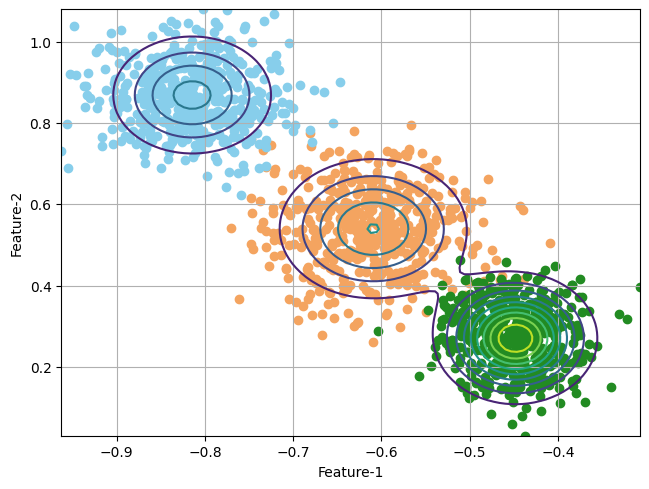

In [57]:
model = SlotAutoencoder(num_slots = num_slots, 
                        num_inputs = num_inputs, 
                        routing_iters = num_inputs)
optimizer = AdamW(
        model.parameters(), 
        lr=lr, 
        weight_decay=wd
    )

loss_np = 0
pbar = tqdm(range(nepochs))

for _  in pbar:
    optimizer.zero_grad()
    x, _, _, slots, sigma, attn, pi = model(data)
    loss = F.mse_loss(x, data)
    # x = F.sigmoid(x)
    # loss = F.binary_cross_entropy(x, data) 
    loss.backward()
    optimizer.step()

    loss_np = loss.item()
    pbar.set_description("Training Loss:{:.2f}".format(loss_np))
    

slots = slots[0].detach().cpu(); sigma = sigma[0].detach().cpu(); pi = pi[0].detach().cpu()
dist = torch.distributions.Normal(slots, sigma)
samples = dist.sample([500])

plt.clf()
plt.scatter(samples[:, 0, 0], samples[:, 0, 1], c='sandybrown')
plt.scatter(samples[:, 1, 0], samples[:, 1, 1], c='forestgreen')
plt.scatter(samples[:, 2, 0], samples[:, 2, 1], c='skyblue')


def gaussian_log_prob(x, loc, scale):
    return (
        -0.5 * torch.tensor(2 * torch.pi, device=x.device).log()
        - torch.log(scale)
        - 0.5 * (x - loc) ** 2 / scale ** 2
    )

datanp = samples.view(-1, 2)
x, y = np.meshgrid(np.linspace(datanp[:, 0].min(), datanp[:, 0].max(), 100),
                   np.linspace(datanp[:, 1].min(), datanp[:, 1].max(), 100))

coord = np.array([x.ravel(), y.ravel()]).T
coord = torch.from_numpy(coord).unsqueeze(1)
log_probs = torch.log(pi) + gaussian_log_prob(coord, slots, sigma).sum(dim=-1, keepdim=True)
likelihood = log_probs.exp().sum(dim=1).reshape(x.shape)
plt.contour(x, y, likelihood, levels=10)
plt.tight_layout()

plt.grid()
plt.xlabel('Feature-1')
plt.ylabel('Feature-2')
plt.show()
